<a href="https://colab.research.google.com/github/erilycus/Advanced-Cybersecurity-Lab/blob/main/notebooks/vison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision With SegFormer and Hugging Face

# Setup

In [2]:
import random
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Optional, Dict, List
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
# Hugging Face
from datasets import load_dataset

## Install required libraries

In [3]:
from packaging import version

# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
required_torch = "1.12.0"
required_torchvision = "0.13.0"

if version.parse(torch.__version__) < version.parse(required_torch) or \
   version.parse(torchvision.__version__) < version.parse(required_torchvision):
    print("[INFO] torch/torchvision versions not as required, installing latest versions.")
    # You can change cu121 to cu118 or cpu as needed
    import os
    os.system("pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
    # Reload torch and torchvision to reflect new versions
    import importlib
    importlib.reload(torch)
    importlib.reload(torchvision)

print(f"✅ torch version: {torch.__version__}")
print(f"✅ torchvision version: {torchvision.__version__}")

✅ torch version: 2.8.0+cu126
✅ torchvision version: 0.23.0+cu126


## Setup Platform

## Mount Drive

Uncomment the lines to mount google drive if using **google colab**.

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup Device-Agnostic Code

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
print(f"✅ Using Device: {DEVICE}")

✅ Using Device: cpu


## Setup Seeds

In [6]:
def set_seeds(seed: int = 42):
    """Sets seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [7]:
set_seeds()

# Data Preparation

## Dataset Structure

In [11]:
class FoodSeg103Dataset(Dataset):
    """
    PyTorch Dataset wrapper for the Hugging Face FoodSeg103 dataset.

    Each sample includes:
        - image (PIL Image)
        - label (segmentation mask as PIL Image)
        - classes_on_image (list of class IDs present)
        - id (int)

    Supports:
        - Hugging Face AutoImageProcessor (for SegFormer preprocessing)
        - Optional torchvision transforms (for flexibility)
    """
    def __init__(self, hf_dataset, processor=None, transform=None):
        """
        Args:
            hf_dataset: A split of the FoodSeg103 dataset loaded via Hugging Face (`datasets.load_dataset`).
            processor: Hugging Face processor (e.g., SegFormer’s AutoImageProcessor).
            transform: Optional torchvision-style transform for images.
        """
        self.dataset = hf_dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        image = item["image"] # PIL Image
        label = item["label"] # PIL Image Mask

        # --- Use Hugging Face processor if available ---
        if self.processor is not None:
            encoded = self.processor(image, segmentation_maps=label, return_tensors="pt")
            pixel_values = encoded["pixel_values"].squeeze(0)
            labels = encoded["labels"].squeeze(0).long()
            return pixel_values, labels

        # --- Otherwise, use torchvision transforms manually (Fallback) ---
        if self.transform:
            image = self.transform(image)

        label = np.array(label, dtype=np.int64)
        label = torch.as_tensor(label, dtype=torch.long)

        return image, label

    def __repr__(self):
        transform_str = str(self.transform) if self.transform else "None"
        processor_str = self.processor.__class__.__name__ if self.processor else "None"
        return (
            f"Dataset FoodSeg103\n"
            f"    Number of datapoints: {len(self)}\n"
            f"    HuggingFace split: {getattr(self.dataset, 'split', 'unknown')}\n"
            f"    Processor: {processor_str}\n"
            f"    Transform: {transform_str}"
        )

## Class Mappings

In [45]:
import json

def load_class_mappings(json_path):
    """
    Load id2label and label2id mappings from a JSON file.

    Args:
        json_path (str): Path to the JSON file like:
            {
              "0": "background",
              "1": "candy",
              "2": "egg tart",
              ...
            }

    Returns:
        tuple: (id2label: dict[int, str], label2id: dict[str, int])
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Convert string keys to integers for id2label
    id2label = {int(k): v for k, v in data.items()}
    label2id = {v: int(k) for k, v in id2label.items()}

    return id2label, label2id

In [46]:
id2label, label2id = load_class_mappings("/content/drive/MyDrive/datasets/foodSeg103/classnames.json")

print("First 5 id2label:")
print(dict(list(id2label.items())[:5]))

print("\nFirst 5 label2id:")
print(dict(list(label2id.items())[:5]))

First 5 id2label:
{0: 'background', 1: 'candy', 2: 'egg tart', 3: 'french fries', 4: 'chocolate'}

First 5 label2id:
{'background': 0, 'candy': 1, 'egg tart': 2, 'french fries': 3, 'chocolate': 4}


## Create DataLoaders

In [47]:
from torchvision import transforms

NUM_WORKERS = os.cpu_count() or 2 # Use 2 Workers as default

class Split(Enum):
    TRAIN = "train"
    VALIDATION = "validation"
    TEST = "test"
    ALL = "all"

def create_dataloaders_from_hf(
    dataset_name: str,
    split: Split = Split.ALL,
    transform: Optional[transforms.Compose] = None,
    processor= None,
    batch_size: int = 4,
    num_workers: int = NUM_WORKERS,
) -> Tuple[Optional[DataLoader], Optional[DataLoader], Optional[DataLoader]]:
    """
    Create PyTorch DataLoaders from a Hugging Face dataset like FoodSeg103.

    Args:
        dataset_name (str): Hugging Face dataset name.
        transform: torchvision transforms to perform on data.
        split (Split): Which split(s) to load (TRAIN, VALIDATION, TEST, or ALL).
        batch_size (int): Batch size for DataLoaders.
        num_workers (int): Number of DataLoader workers.
    Returns:
        (train_loader, val_loader, test_loader): Tuple of DataLoaders.
        Unused splits will be returned as None.
    """

    def build_loader(split_name: str, is_train: bool = False) -> DataLoader:
        ds = load_dataset(dataset_name, split=split_name)
        dataset = FoodSeg103Dataset(ds, transform=transform, processor=processor)
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=is_train,
            drop_last=is_train,
            num_workers=num_workers,
            pin_memory=True,
        )

    # --- Load splits ---
    train_loader = val_loader = test_loader = None
    if split in (Split.TRAIN, Split.ALL):
        train_loader = build_loader("train", is_train=True)

    if split in (Split.VALIDATION, Split.ALL):
        val_loader = build_loader("validation")

    if split in (Split.TEST, Split.ALL):
        try:
            test_loader = build_loader("test")
        except ValueError:
            print(f"⚠️ No 'test' split found in dataset: {dataset_name}")

    return train_loader, val_loader, test_loader

# Model Pipeline

## Builder

In [50]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig, AutoImageProcessor

class SegformerBuilder:
    """
    A flexible builder for creating and configuring SegFormer models
    from the Hugging Face Transformers library.
    """

    def __init__(
        self,
        model_name: str = "nvidia/segformer-b0-finetuned-ade-512-512",
        num_classes: int = 104,
        ignore_mismatched_sizes: bool = True,
        use_pretrained: bool = True,
        device: str = DEVICE,
    ):
        """
        Initialize the SegformerBuilder.

        Args:
            model_name (str): Pretrained SegFormer model name or path.
            num_classes (int): Number of segmentation classes.
            ignore_mismatched_sizes (bool): Allow different output head sizes.
            use_pretrained (bool): Whether to load pretrained weights.
            device (str): Device to load model on ("cuda" or "cpu").
        """
        self.model_name = model_name
        self.num_classes = num_classes
        self.ignore_mismatched_sizes = ignore_mismatched_sizes
        self.use_pretrained = use_pretrained
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")

        # Load model config Parameters
        id2label, label2id = load_class_mappings("/content/drive/MyDrive/datasets/foodSeg103/classnames.json")
        self.config = SegformerConfig.from_pretrained(
            model_name,
            num_labels=num_classes,
            hidden_dropout_prob=0.1,
            id2label=id2label,
            label2id=label2id
        )

        # Load model weights (optionally pretrained)
        if use_pretrained:
            self.model = SegformerForSemanticSegmentation.from_pretrained(
                model_name,
                config=self.config,
                ignore_mismatched_sizes=ignore_mismatched_sizes,
            )
        else:
            self.model = SegformerForSemanticSegmentation(config=self.config)

        # Load image processor (for transforms)
        self.processor = AutoImageProcessor.from_pretrained(model_name)

        # Set model to device
        self.model.to(self.device)

    def get_model(self) -> torch.nn.Module:
        """Return the PyTorch model."""
        return self.model

    def get_processor(self):
        """Return the Hugging Face image processor for transforms."""
        return self.processor

    def freeze_encoder(self, freeze=True):
        """Freeze or unfreeze the encoder layers."""
        for param in self.model.segformer.encoder.parameters():
            param.requires_grad = not freeze
        print(f"Encoder frozen: {freeze}")

    def freeze_decoder(self, freeze=True):
        """Freeze or unfreeze the decoder layers."""
        for param in self.model.decode_head.parameters():
            param.requires_grad = not freeze
        print(f"Decoder frozen: {freeze}")

    def unfreeze_all(self):
        """Unfreeze all parameters."""
        for param in self.model.parameters():
            param.requires_grad = True
        print("All model parameters are trainable.")

    def summary(self):
        """Print basic info about the model."""
        print("\n🧩 SegFormer Model Summary\n")
        print(f"Model: {self.model_name}")
        print(f"Classes: {self.num_classes}")
        print(f"Device: {self.device}")
        print(f"Parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Trainable: {sum(p.numel() for p in self.model.parameters() if p.requires_grad):,}")
        # Add shape info
        size = self.processor.size.get("height", 512)
        dummy = torch.randn(1, 3, size, size).to(self.device)
        with torch.no_grad():
            out = self.model(pixel_values=dummy)
        print(f"Output keys: {list(out.keys())}")
        print(f"Logits shape: {out.logits.shape}")

In [51]:
builder = SegformerBuilder(num_classes=104)
builder.summary()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([104]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([104, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)



🧩 SegFormer Model Summary

Model: nvidia/segformer-b0-finetuned-ade-512-512
Classes: 104
Device: cpu
Parameters: 3,740,872
Trainable: 3,740,872
Output keys: ['logits']
Logits shape: torch.Size([1, 104, 128, 128])


In [52]:
# # --- Define image transforms ---
# def create_transforms(image_size: int = 512) -> torchvison.transforms.Compose:
#     return trorchvision.transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])
# transform = create_transforms()

# Processor with Hugging Face

# Creating DataLaoders
train_loader, validation_loader, _ = create_dataloaders_from_hf(
    dataset_name="EduardoPacheco/FoodSeg103",
    split=Split.ALL,
    transform=None,
    processor=builder.get_processor()
)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

⚠️ No 'test' split found in dataset: EduardoPacheco/FoodSeg103


## Random Visualization from Dataset

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_image_with_mask(image, mask=None, alpha=0.5):
    """
    Visualize an image, its segmentation mask, and overlay.

    Args:
        image (np.ndarray or PIL.Image.Image): RGB image.
        mask (np.ndarray or PIL.Image.Image): Segmentation mask (H x W).
        alpha (float): Transparency for overlay blending.
    """
    # Convert PIL → NumPy if needed
    img = np.array(image)
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    h, w = img.shape[:2]

    mask_np = None
    if mask is not None:
        mask_np = np.array(mask, dtype=np.int64)

        # --- Resize mask to match image if needed ---
        if mask_np.shape[:2] != (h, w):
            mask_np = cv2.resize(
                mask_np, (w, h), interpolation=cv2.INTER_NEAREST
            )

        # --- Random color map for classes ---
        unique_classes = np.unique(mask_np)
        color_map = {cls: np.random.randint(0, 255, size=3) for cls in unique_classes if cls != 0}

        color_mask = np.zeros_like(img)
        for cls_id, color in color_map.items():
            color_mask[mask_np == cls_id] = color

        # Blend image + color mask
        blended = cv2.addWeighted(img, 1 - alpha, color_mask, alpha, 0)
    else:
        blended = img

    # --- Plot all ---
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    if mask_np is not None:
        plt.imshow(mask_np, cmap="tab20")
        plt.title("Segmentation Mask (Class IDs)")
    else:
        plt.text(0.5, 0.5, "No mask", ha="center", va="center")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title("Overlay (Image + Mask)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # --- Metadata ---
    if mask_np is not None:
        coverage = np.count_nonzero(mask_np) / mask_np.size * 100
        print(f"✅ Mask Coverage: {coverage:.2f}% of image")
        print(f"🟢 Unique classes: {np.unique(mask_np).tolist()}")
        print(f"📏 Image size: {img.shape}")
        print(f"🎭 Mask size: {mask_np.shape}")

In [54]:
def display_random_sample(dataset, seed: int = 42):
    """
    Displays a random image and its mask from a PyTorch dataset.

    Args:
        dataset (Dataset): A PyTorch dataset that returns (image, mask) pairs.
    """
    # Pick random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    # If tensors → convert to NumPy (for plotting)
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()  # CHW → HWC
        image_np = np.clip(image_np, 0, 1)
    else:
        image_np = np.array(image)

    if isinstance(mask, torch.Tensor):
        mask_np = mask.numpy()
    else:
        mask_np = np.array(mask)

    # --- Print metadata ---
    print(f"🖼️ Sample Index: {idx}")

    print("\n")
    # --- Visualize using helper ---
    visualize_image_with_mask(image_np, mask_np)

🖼️ Sample Index: 912




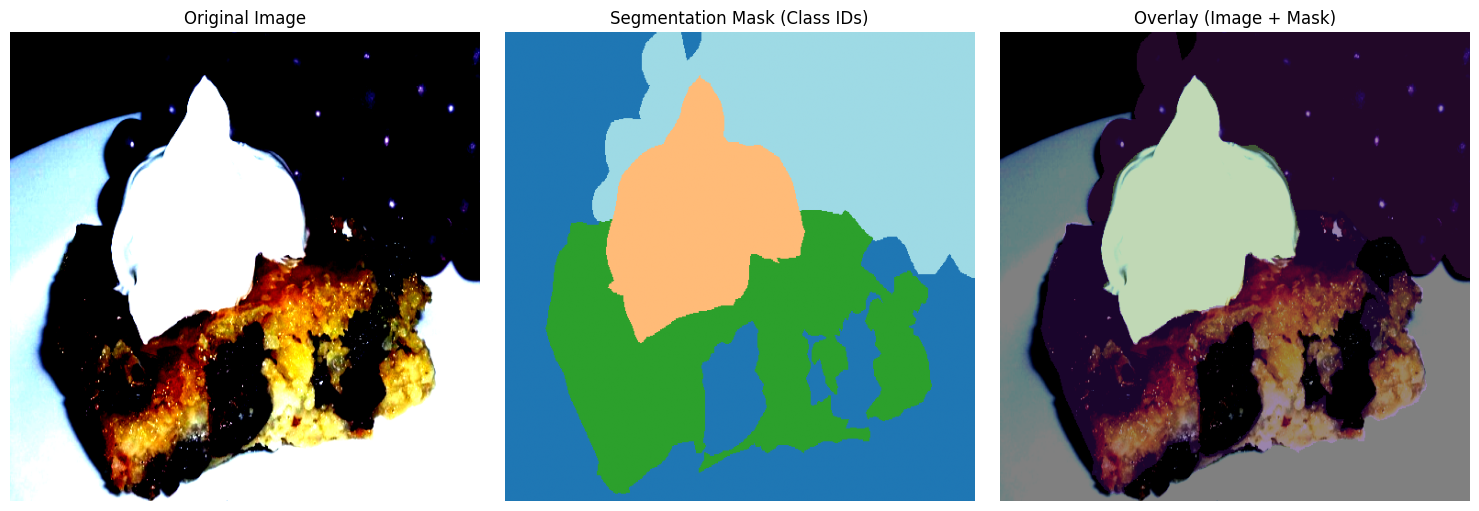

✅ Mask Coverage: 62.85% of image
🟢 Unique classes: [0, 8, 10, 41]
📏 Image size: (512, 512, 3)
🎭 Mask size: (512, 512)


In [55]:
# Displaying Random Sample
display_random_sample(train_loader.dataset)

## Engine

In [59]:
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from torch.amp import autocast, GradScaler


# ==========================
# 🔹 Metric Helpers
# ==========================
def pixel_accuracy(preds, labels):
    """Compute pixel-wise accuracy."""
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total


def intersection_over_union(preds, labels, num_classes, ignore_index=255):
    """Compute mean IoU for multi-class segmentation."""
    ious = []
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = np.logical_or(pred_inds, label_inds).sum()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0.0


# ==========================
# 🔹 Checkpoint Utilities
# ==========================
def save_checkpoint(model, optimizer, scheduler, epoch, best_miou,
                    path="checkpoints", filename="best_segformer.pt"):
    os.makedirs(path, exist_ok=True)
    checkpoint_path = os.path.join(path, filename)
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
            "best_miou": best_miou,
        },
        checkpoint_path,
    )
    print(f"✅ Checkpoint saved at: {checkpoint_path}")


def load_checkpoint(model, optimizer=None, scheduler=None,
                    path="checkpoints/segformer_best.pt", device="cuda"):
    """Load model and optimizer states from checkpoint."""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler and checkpoint["scheduler_state_dict"]:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch'] + 1}, "
          f"best mIoU={checkpoint['best_miou']:.4f}")
    return checkpoint


# ==========================
# 🔹 Training Step
# ==========================
def train_step(model, dataloader, loss_fn, optimizer, device, num_classes, scaler):
    model.train()
    train_loss, train_acc, train_iou = 0, 0, 0
    autocast_device = "cuda" if torch.cuda.is_available() else "cpu"

    for images, labels in tqdm(dataloader, leave=False, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision forward
        with autocast(device_type=autocast_device, enabled=torch.cuda.is_available()):
            outputs = model(pixel_values=images)
            logits = torch.nn.functional.interpolate(
                outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            loss = loss_fn(logits, labels)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_acc += pixel_accuracy(preds, labels)
        train_iou += intersection_over_union(preds, labels, num_classes)

    n = len(dataloader)
    return train_loss / n, train_acc / n, train_iou / n


# ==========================
# 🔹 Evaluation Step
# ==========================
def test_step(model, dataloader, loss_fn, device, num_classes):
    model.eval()
    test_loss, test_acc, test_iou = 0, 0, 0

    with torch.inference_mode():
        for images, labels in tqdm(dataloader, leave=False, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(pixel_values=images)
            logits = torch.nn.functional.interpolate(
                outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            loss = loss_fn(logits, labels)

            test_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            test_acc += pixel_accuracy(preds, labels)
            test_iou += intersection_over_union(preds, labels, num_classes)

    n = len(dataloader)
    return test_loss / n, test_acc / n, test_iou / n


# ==========================
# 🔹 Main Training Loop
# ==========================
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    epochs,
    device,
    num_classes,
    scheduler=None,
    save_dir="checkpoints",
    min_best_miou=0.5  # Minimum threshold to save model
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_cuda = torch.cuda.is_available()
    scaler = GradScaler(device="cuda") if use_cuda else None

    best_miou = 0.0
    results = {
        "train_loss": [], "train_acc": [], "train_iou": [],
        "test_loss": [], "test_acc": [], "test_iou": [],
        "epoch_time": []
    }

    model.to(device)

    for epoch in range(epochs):
        start_time = time.perf_counter()

        print(f"\n🌱 Epoch [{epoch + 1}/{epochs}]")
        train_loss, train_acc, train_iou = train_step(
            model, train_dataloader, loss_fn, optimizer, device, num_classes, scaler
        )
        test_loss, test_acc, test_iou = test_step(
            model, test_dataloader, loss_fn, device, num_classes
        )

        if scheduler:
            scheduler.step()

        epoch_time = time.perf_counter() - start_time
        results["epoch_time"].append(epoch_time)

        tqdm.write(
            f"🕒 Time: {epoch_time:.2f}s | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, mIoU: {train_iou:.4f} | "
            f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, mIoU: {test_iou:.4f}"
        )

        # Save best model (if meets minimum threshold)
        if test_iou > best_miou and test_iou >= min_best_miou:
            best_miou = test_iou
            save_checkpoint(model, optimizer, scheduler, epoch, best_miou, path=save_dir)

        # Periodic checkpoints
        if (epoch + 1) % 5 == 0:
            save_checkpoint(
                model, optimizer, scheduler, epoch, best_miou,
                path=save_dir, filename=f"segformer_epoch_{epoch + 1}.pt"
            )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_iou"].append(train_iou)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_iou"].append(test_iou)

    print("\n🎯 Training complete!")
    print(f"🏆 Best validation mIoU: {best_miou:.4f}")
    avg_time = np.mean(results["epoch_time"])
    print(f"⏱️ Average epoch time: {avg_time:.2f} seconds")

    return results


## Fine Tunning

In [60]:
# Initialize model and processor
model = builder.get_model()
processor = builder.get_processor()

# Loss (ignore_index=255 if present in dataset)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Fine-tune
if __name__ == "__main__":
    training_results = train(
        model=model,
        train_dataloader=train_loader,
        test_dataloader=validation_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=20, # Trainning for 20 Epoch
        device=builder.device,
        num_classes=builder.num_classes,
        scheduler=scheduler,
        save_dir="../models"
    )

# Later (for inference or resuming)
# load_checkpoint(model, path="./checkpoints/segformer_best.pt", device=builder.device)
# model.eval()


🌱 Epoch [1/20]


Training:   0%|          | 0/1245 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

## Save Model Checkpoint Manually

The model can be saved via `model.save_pretrained("./segformer_finetuned")` or `builder.get_processor().save_pretrained("./segformer_finetuned")`. any of the method works.

You can use this code for loading the model in inference.
```python
from transformers import SegformerForSemanticSegmentation, AutoImageProcessor
# Load model wither via `SegformerForSemanticSegmentation`
model = SegformerForSemanticSegmentation.from_pretrained("./segformer_finetuned")
# the mode can also be loaded via AutoImageProcessor
processor = AutoImageProcessor.from_pretrained("./segformer_finetuned")
```

In [ ]:
model_path="./segformer_finetuned"
# model.save_pretrained("./segformer_finetuned")
builder.get_processor().save_pretrained(model_path)
print(f"🎫Saved Pretained Processor to: {model_path}")